# **Black Friday Sale Predictions - GROUP 07 - DSAI - K65** 
*Colab Version*

## 1.&nbsp;Setup the datasets

Download file data .zip from Google Drive

In [ ]:
!gdown 1ch8GFCDyeP3DPJIADOYN1mdHs21x__5T

Downloading...
From: https://drive.google.com/uc?id=1ch8GFCDyeP3DPJIADOYN1mdHs21x__5T
To: /content/BlackFridayDatasets.zip
100% 7.70M/7.70M [00:00<00:00, 73.9MB/s]


Unzip the downloaded data file

In [ ]:
FOLDER_PATH = r'/content/BlackFridayDatasets/'
!unzip -o "/content/BlackFridayDatasets.zip" -d  $FOLDER_PATH

Archive:  /content/BlackFridayDatasets.zip
  inflating: /content/BlackFridayDatasets/data_description.txt  
  inflating: /content/BlackFridayDatasets/test.csv  
  inflating: /content/BlackFridayDatasets/train.csv  


Setup folder path for the training test and test dataset

In [ ]:
TRAIN_DATA_PATH = FOLDER_PATH + r'train.csv'
TEST_DATA_PATH = FOLDER_PATH + r'test.csv'

Check whether we are in the right paths

In [ ]:
import os 
print("All files in folder data are: " + str(os.listdir(FOLDER_PATH)))
print("Is exists train file? " + str(os.path.exists(TRAIN_DATA_PATH)))
print("Is exists test file? " + str(os.path.exists(TEST_DATA_PATH)))

All files in folder data are: ['test.csv', 'train.csv', 'data_description.txt']
Is exists train file? True
Is exists test file? True


*Our expected output is:* 
```
All files in folder data are: ['test.csv', 'train.csv', 'data_description.txt']
Is exists train file? True
Is exists test file? True
```


**Now we are ready to move on to the main section.**

## 2.&nbsp;Setup the datasets

In [2]:
import time
import random


import gc; gc.enable() #Enable garbage for the notebook

import numpy as np 
import pandas as pd

# Plot diagrams 
import matplotlib.pyplot as plt
import seaborn as sns

## Sklearn for data preprocessing modelling,  and evaluation 
from sklearn.model_selection import cross_validate, validation_curve, learning_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline

## For xgboost model
from xgboost import XGBRegressor


## For normal test
from scipy.stats import normaltest

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


## Setup graph style
import matplotlib.style as style
style.use('seaborn-poster')
style.use("fivethirtyeight")
plt.rcParams['font.family'] = 'monospace'

## 3.&nbsp;Exploratory Data Analysis (EDA)

In [ ]:
# Read data from csv file
train_raw = pd.read_csv(TRAIN_DATA_PATH)
test_raw = pd.read_csv(TEST_DATA_PATH)

In [ ]:
# Let's see some data
train_raw.head(10)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969
5,1000003,P00193542,M,26-35,15,A,3,0,1,2.0,NaN,15227
6,1000004,P00184942,M,46-50,7,B,2,1,1,8.0,17.0,19215
7,1000004,P00346142,M,46-50,7,B,2,1,1,15.0,NaN,15854
8,1000004,P0097242,M,46-50,7,B,2,1,1,16.0,NaN,15686
9,1000005,P00274942,M,26-35,20,A,1,1,8,NaN,NaN,7871


In [ ]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


 We can easy see that all non-target attributes are categorical (more specifically nominal).

 There is no missing information related to users but there are large numbers of null values for products (Product_Category_2,  Product_Category_3). 

There are also some questions on top of our head that we need to answer

### 3.1. Which type of users spent most money on buying products?

In [ ]:
# We just consider 3 colomns as we just care about one specific user 
user_df = train_raw.loc[:, ["User_ID", "Product_ID", "Purchase"]]
user_df.head(3)

,User_ID,Product_ID,Purchase
0,1000001,P00069042,8370
1,1000001,P00248942,15200
2,1000001,P00087842,1422


In [ ]:
# Are there any users buy 1 product with different prices ?
nb_user = user_df[user_df.duplicated()].shape[0]
user_df1 = user_df.drop(columns="Purchase")
nb_user1 = user_df1[user_df1.duplicated()].shape[0]
print("Number of user buy a product more than once with same price:", nb_user)
print("Number of user buy a product more than once:", nb_user1)

Number of user buy a product more than once with same price: 0
Number of user buy a product more than once: 0


=> Each product may be bought by an user at most one time.

Next we calculate the number of products and total amount of money each user spent in the data.

In [ ]:
user_df2 = train_raw.drop(columns=["Product_ID", "Product_Category_1", 'Product_Category_2', 'Product_Category_3', 'Purchase'])
user_df3 = train_raw[["User_ID", "Purchase"]]

# u1: dataframe contains User_ID and Purchase: total amount of money that user spent
u1 = user_df3.groupby("User_ID", as_index = False).agg({'Purchase': 'sum'})

# u2: dataframe contains User_ID and number of products that user purchase (using count)
u2 = user_df3.groupby("User_ID", as_index = False).agg({'Purchase': 'count'})

# merging u1 and u2 with user_df2 on 'User_ID' 
user_df2 = pd.merge(user_df2, u1, on='User_ID')
user_df2.rename(columns={"Purchase":"TotalPurchase"}, inplace=True)
user_df2 = pd.merge(user_df2, u2, on='User_ID')
user_df2.rename(columns={"Purchase":"nb_products"}, inplace=True)

# Avg_money_per_product: average amount of money an user spent for 1 product
user_df2["Avg_money_per_product"] = round(user_df2.TotalPurchase / user_df2.nb_products, 2)

user_df2.drop_duplicates(inplace=True)
user_df2.reset_index(inplace=True, drop=True)

user_df2.sort_values(by='nb_products', ascending=False, ignore_index=True).head(7)
user_df2_copy = user_df2.copy()

Next, we plot the relationship between number of products and spending money of users

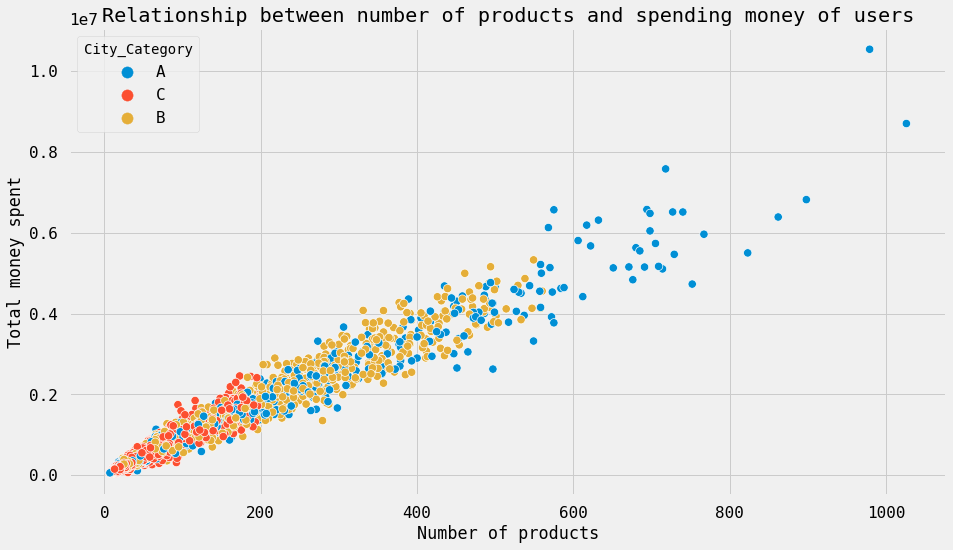

In [ ]:
plt.figure(figsize=(14,8))
sns.scatterplot(data=user_df2, x='nb_products', y='TotalPurchase', hue="City_Category", s=70)

plt.title("Relationship between number of products and spending money of users")
plt.ylabel("Total money spent")
plt.xlabel("Number of products")

plt.show()

It seems that people in city A spent most for products, B is right behind and C is the least.*


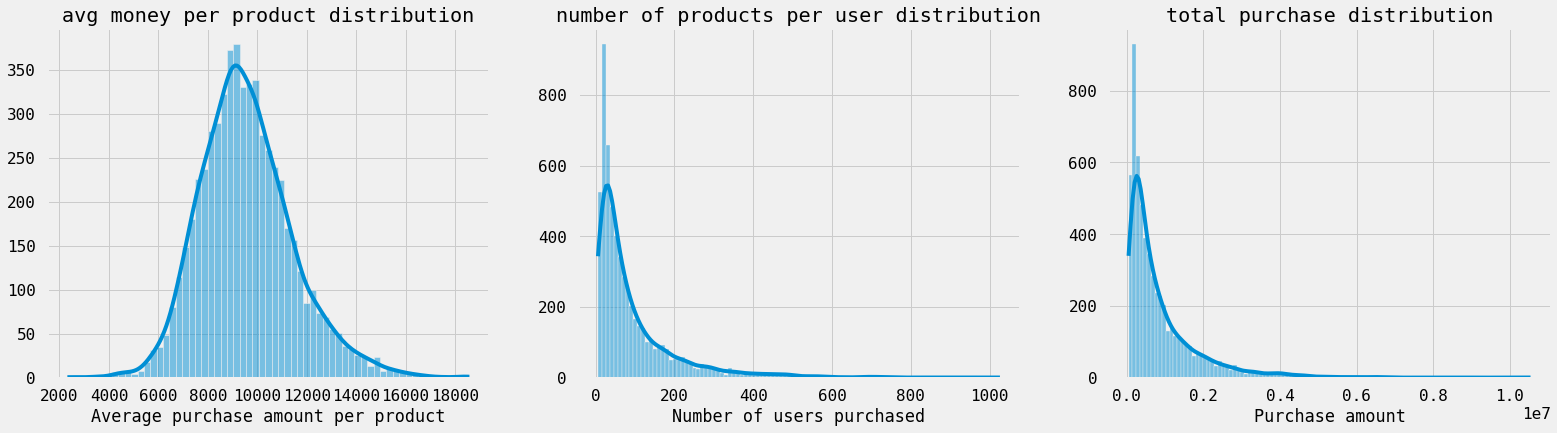

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (24,6))

sns.histplot(ax= ax[0], data=user_df2.Avg_money_per_product, kde=True)
sns.histplot(ax= ax[1], data= user_df2.nb_products, kde= True)
sns.histplot(ax=ax[2], data= user_df2.TotalPurchase, kde = True)
ax[0].set(title="avg money per product distribution", ylabel = None, xlabel="Average purchase amount per product")
ax[1].set(title="number of products per user distribution", ylabel = None, xlabel="Number of users purchased")
ax[2].set(title="total purchase distribution", xlabel="Purchase amount", ylabel=None)

plt.show() 

In [ ]:
_, p_value = normaltest(a=user_df2.Avg_money_per_product)
print("p value:", p_value)

p value: 1.4617254783853661e-78


The p value is so small that mean the distribution is not normal so it is totally imbalanced regression problem.

### 3.2. Which types of user use money more efficient?

In [ ]:
user_df4 = train_raw.loc[:, ["Product_ID", "Purchase"]]
user_df5 = train_raw.loc[:, ["User_ID", "Product_ID", "Purchase"]]

# u4:dataframe contains Product_ID and average of money user spent for that product
u4 = user_df4.groupby(by='Product_ID', as_index=False).agg({"Purchase":"mean"})
u4.rename(columns={"Purchase":"Avg_amount"}, inplace=True)

user_df5 = pd.merge(user_df5, u4, on='Product_ID')
user_df5['Saving'] = round(user_df5.Avg_amount - user_df5.Purchase, 2)

user_df5.head(5)

,User_ID,Product_ID,Purchase,Avg_amount,Saving
0,1000001,P00069042,8370,11870.863436,3500.86
1,1000149,P00069042,10715,11870.863436,1155.86
2,1000541,P00069042,11037,11870.863436,833.86
3,1000698,P00069042,8009,11870.863436,3861.86
4,1000951,P00069042,13346,11870.863436,-1475.14


In [ ]:
u5 = user_df5.groupby(by="User_ID", as_index=False).agg({"Saving":"sum"})

user_df2 = pd.merge(user_df2_copy, u5, on="User_ID")

user_df2.head(4)


,User_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,TotalPurchase,nb_products,Avg_money_per_product,Saving
0,1000001,F,0-17,10,A,2,0,334093,35,9545.51,-7174.27
1,1000002,M,55+,16,C,4+,0,810472,77,10525.61,11770.64
2,1000003,M,26-35,15,A,3,0,341635,29,11780.52,-13024.32
3,1000004,M,46-50,7,B,2,1,206468,14,14747.71,-4685.82


In [ ]:
user_df2['saving_score'] = round(user_df2.Saving / user_df2.TotalPurchase, 2)
user_df2.sort_values(by="saving_score", ignore_index=True, ascending=False).head(6)

,User_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,TotalPurchase,nb_products,Avg_money_per_product,Saving,saving_score
0,1003598,M,55+,1,A,2,0,113331,42,2698.36,222084.38,1.96
1,1004486,M,36-45,8,C,1,0,69562,30,2318.73,117960.88,1.70
2,1002744,M,18-25,17,C,1,1,314780,92,3421.52,455274.69,1.45
3,1004539,M,36-45,19,C,0,0,295996,70,4228.51,378837.70,1.28
4,1004636,M,18-25,2,B,2,1,57805,16,3612.81,70365.35,1.22
5,1005944,F,18-25,10,C,4+,0,53996,15,3599.73,57382.24,1.06


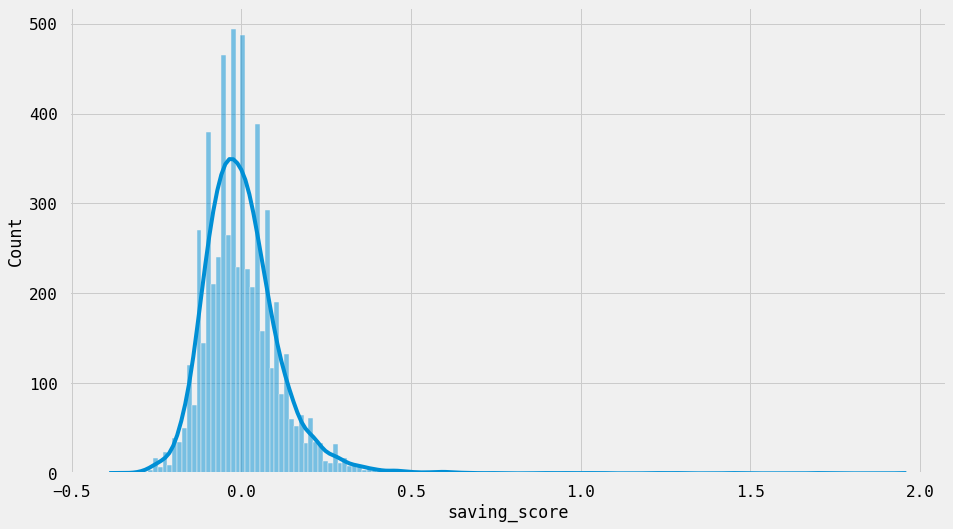

In [ ]:
plt.figure(figsize=(14,8))
sns.histplot(data=user_df2.saving_score, kde=True)

In [ ]:
user_df2['saving_score'] = round(user_df2.Saving / user_df2.TotalPurchase, 2)
user_df2.sort_values(by="saving_score", ignore_index=True, ascending=False).head(6)

,User_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,TotalPurchase,nb_products,Avg_money_per_product,Saving,saving_score
0,1003598,M,55+,1,A,2,0,113331,42,2698.36,222084.38,1.96
1,1004486,M,36-45,8,C,1,0,69562,30,2318.73,117960.88,1.70
2,1002744,M,18-25,17,C,1,1,314780,92,3421.52,455274.69,1.45
3,1004539,M,36-45,19,C,0,0,295996,70,4228.51,378837.70,1.28
4,1004636,M,18-25,2,B,2,1,57805,16,3612.81,70365.35,1.22
5,1005944,F,18-25,10,C,4+,0,53996,15,3599.73,57382.24,1.06


In [ ]:
user_df2.groupby('City_Category').agg({"saving_score":"sum"})

,saving_score
City_Category,
A,19.33
B,18.46
C,-23.57


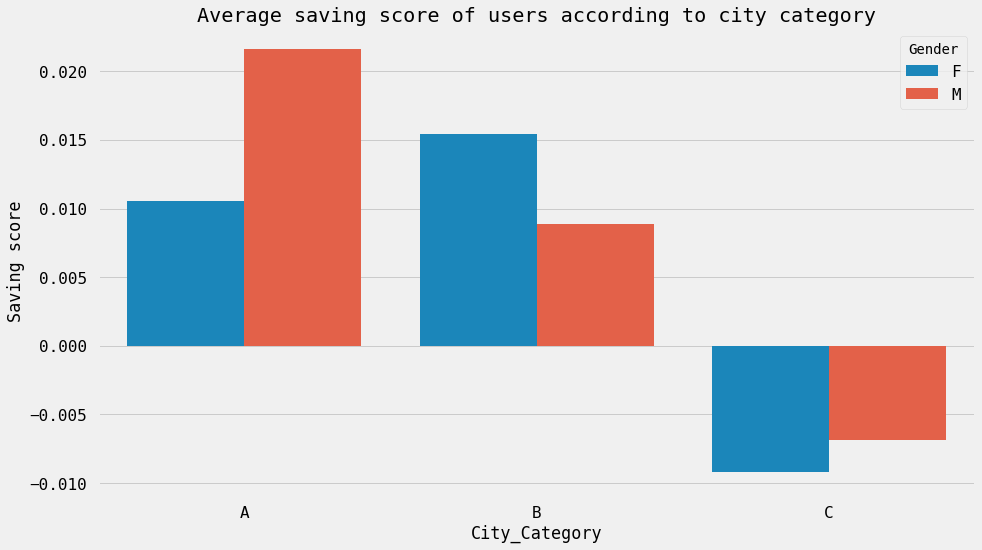

In [ ]:
plt.figure(figsize=(14,8))
sns.barplot(data=user_df2, y='saving_score', x='City_Category', hue='Gender', ci=False, order=["A", "B", "C"])

plt.ylabel("Saving score")
plt.title("Average saving score of users according to city category")

plt.savefig("saving_user_city.png")
plt.show()

It seems that people in city C usually buy product with higher price

In general, males in city A use money more efficient than females, and females in city B use money more effiecient than males in city B

### 3.3 Which type of products are more prefer (bought most)?

In [ ]:
product_df = train_raw.loc[:,["User_ID", "Product_ID", "City_Category",  "Product_Category_1","Product_Category_2","Product_Category_3", "Purchase" ]]
product_df['Versatile'] = 3 - product_df.iloc[:,[3,4,5]].isnull().sum(axis = 1)
product_df.head()

,User_ID,Product_ID,City_Category,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Versatile
0,1000001,P00069042,A,3,NaN,NaN,8370,1
1,1000001,P00248942,A,1,6.0,14.0,15200,3
2,1000001,P00087842,A,12,NaN,NaN,1422,1
3,1000001,P00085442,A,12,14.0,NaN,1057,2
4,1000002,P00285442,C,8,NaN,NaN,7969,1


In [ ]:
product_df.Versatile.value_counts()

2    209609
1    173638
3    166821
Name: Versatile, dtype: int64

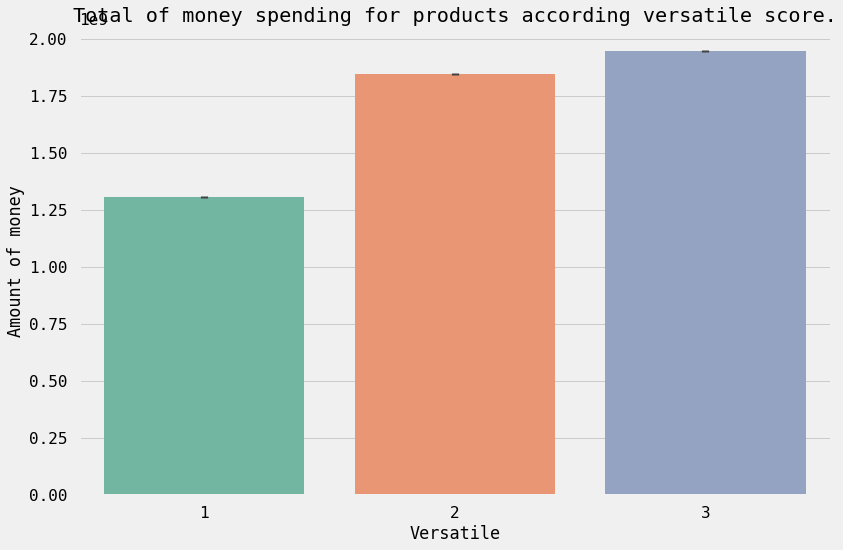

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(data=product_df, x='Versatile', y='Purchase', palette="Set2", estimator=np.sum)

plt.ylabel("Amount of money")
plt.title("Total of money spending for products according versatile score.")
plt.show()

*In general, we can see Versatile score: which product more versatile will have high price*

In [ ]:
# p1: dataframe contains product_id and total money user spent for that product
p1 = product_df.loc[:, ["Product_ID", 'Purchase']]
p1.rename(columns={"Purchase":"total_purchase"}, inplace=True)
p1 = p1.groupby(by="Product_ID", as_index=False).agg({"total_purchase":"sum"})


# p2: dataframe contains product_id and number of users purchased that product
p2 = product_df.loc[:, ["Product_ID", 'Purchase']]
p2.rename(columns={"Purchase":"nb_users_purchase"}, inplace=True)
p2 = p2.groupby(by="Product_ID", as_index=False).agg({"nb_users_purchase":"count"})


product_df1 = product_df.loc[:, ["Product_ID",  "Product_Category_1","Product_Category_2","Product_Category_3", "Versatile"]]
product_df1.drop_duplicates(inplace=True)

product_df1 = pd.merge(product_df1, p1, on='Product_ID')
product_df1 = pd.merge(product_df1, p2, on='Product_ID')

product_df1.head()

,Product_ID,Product_Category_1,Product_Category_2,Product_Category_3,Versatile,total_purchase,nb_users_purchase
0,P00069042,3,NaN,NaN,1,2694686,227
1,P00248942,1,6.0,14.0,3,9472642,581
2,P00087842,12,NaN,NaN,1,126265,102
3,P00085442,12,14.0,NaN,2,496203,341
4,P00285442,8,NaN,NaN,1,1561631,203


In [ ]:
product_df1['avg_amount'] = round(product_df1.total_purchase / product_df1.nb_users_purchase, 2)
product_df1.head()

,Product_ID,Product_Category_1,Product_Category_2,Product_Category_3,Versatile,total_purchase,nb_users_purchase,avg_amount
0,P00069042,3,NaN,NaN,1,2694686,227,11870.86
1,P00248942,1,6.0,14.0,3,9472642,581,16304.03
2,P00087842,12,NaN,NaN,1,126265,102,1237.89
3,P00085442,12,14.0,NaN,2,496203,341,1455.14
4,P00285442,8,NaN,NaN,1,1561631,203,7692.76


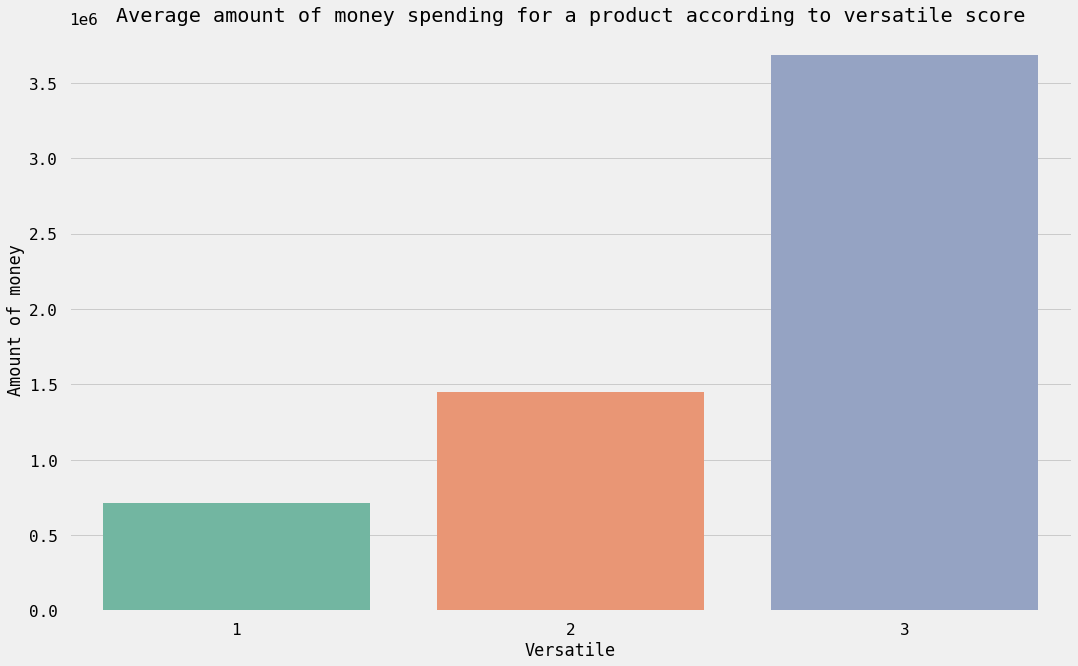

In [ ]:
plt.figure(figsize=(16,10))
sns.barplot(data=product_df1, x='Versatile', y='total_purchase', palette="Set2", ci=False)

plt.ylabel("Amount of money")
plt.title("Average amount of money spending for a product according to versatile score")

plt.show()

In [ ]:
product_df1.sort_values(by= 'nb_users_purchase', ascending=False, ignore_index=True).head(7)

,Product_ID,Product_Category_1,Product_Category_2,Product_Category_3,Versatile,total_purchase,nb_users_purchase,avg_amount
0,P00265242,5,8.0,NaN,2,14165515,1880,7534.85
1,P00025442,1,2.0,9.0,3,27995166,1615,17334.47
2,P00110742,1,2.0,8.0,3,26722309,1612,16577.11
3,P00112142,1,2.0,14.0,3,24216006,1562,15503.20
4,P00057642,1,15.0,16.0,3,23102780,1470,15716.18
5,P00184942,1,8.0,17.0,3,24334887,1440,16899.23
6,P00046742,1,2.0,15.0,3,21152882,1438,14709.93


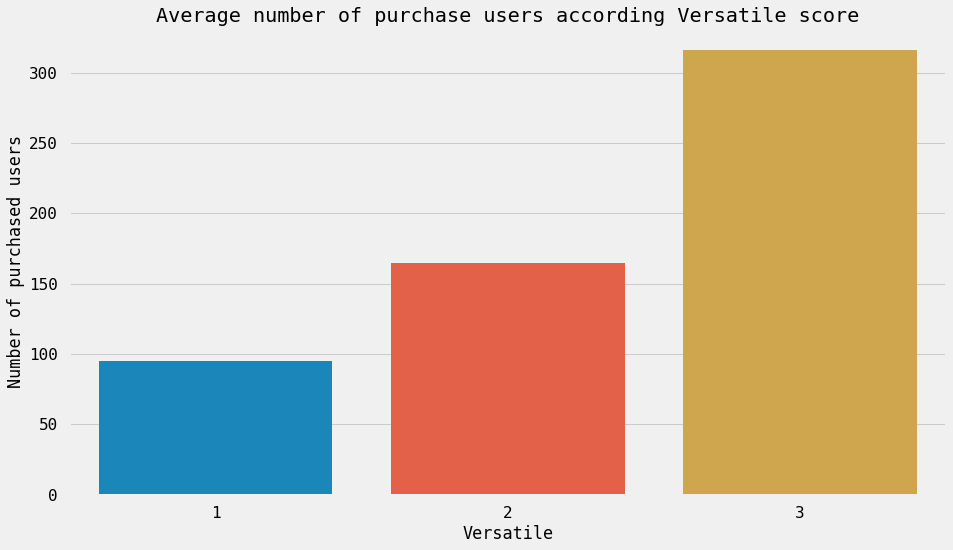

In [ ]:
plt.figure(figsize=(14,8))
sns.barplot(data=product_df1, x='Versatile', y='nb_users_purchase', estimator=np.mean, ci=False)
# plt.xlabel()
plt.title("Average number of purchase users according Versatile score")
plt.ylabel("Number of purchased users")

plt.savefig("nb_purchase_versatile.png")
plt.show()

It seems that in average, a product type 3 is bought more than a product type 2 and type 1, type 1 = 1/2 type 2

That means products which more versatile are more popular, in general.

## 4.&nbsp;Data Preprocessing

Include functions for cleaning data, removing redundancy before the modelling 

In [ ]:
def simple_data_preprocessing(train_raw: pd.DataFrame, test_raw: pd.DataFrame):
  '''
    
  '''
  le = LabelEncoder()

  df_train = train_raw.copy()
  df_test = test_raw.copy()


  df_train.drop(columns = ['Product_Category_2', 'Product_Category_3'], inplace=True)
  df_test.drop(columns = ['Product_Category_2', 'Product_Category_3'] , inplace=True)


  idx = df_train.shape[0]

  y  = df_train['Purchase']
  df_train.drop('Purchase', 1 , inplace= True)

  df_train_test = pd.concat([df_train, df_test], axis = 0)

  columns = ['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation' , 'City_Category' , 'Stay_In_Current_City_Years']

  for col in columns:
    df_train_test[col] = le.fit_transform(df_train_test[col])



  X = df_train_test.iloc[:idx, :]
  test_encode = df_train_test.iloc[idx: , :]

  return X, y , test_encode


def one_hot_encoding_train(df: pd.DataFrame):
    '''
    apply for training set
    one hot encoding ['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years', 'Product_Category_1', 'Occupation']
    label encoding 'Product_ID' -> avoid new product in test set
    drop Product_Category_2 and Product_Category_3
    normalization using StandardScaler() 

    return X training data, and y train labels
    '''
    le = LabelEncoder()
    scl = StandardScaler()
    df.Product_ID = le.fit_transform(df.Product_ID)
    category_col = []
    numerical_col = []
    for column in df.columns:
        if df[column].dtypes == 'object':
            category_col.append(column)

    category_col.append("Product_Category_1")
    category_col.append('Occupation')

    train_encode = pd.get_dummies(df, columns=category_col, dtype = np.uint8, drop_first=True)
    X = train_encode.drop(columns=['Purchase', 'Product_Category_2', "Product_Category_3"])
    y = train_encode.Purchase

    train_cols = X.columns
    train_ind = X.index 
    X = scl.fit_transform(X)
    X = pd.DataFrame(X, columns= train_cols, index=train_ind)
    return X, y


def one_hot_encoding_test(df: pd.DataFrame):
    '''
    apply for test set
    one hot encoding ['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years', 'Product_Category_1', 'Occupation']
    label encoding 'Product_ID' -> avoid new product
    drop Product_Category_2 and Product_Category_3
    normalization using StandardScaler() 

    return X - for making prediction
    '''
    le = LabelEncoder()
    scl = StandardScaler()
    df.Product_ID = le.fit_transform(df.Product_ID)
    category_col = []
    numerical_col = []
    for column in df.columns:
        if df[column].dtypes == 'object':
            category_col.append(column)
    category_col.append("Product_Category_1")
    category_col.append('Occupation')

    test_encode = pd.get_dummies(df, columns=category_col, dtype = np.uint8, drop_first=True)
    X = test_encode.drop(columns=['Product_Category_2', "Product_Category_3"])

    test_cols = X.columns
    test_ind = X.index 
    X = scl.fit_transform(X)
    X = pd.DataFrame(X, columns= test_cols, index=test_ind)
    return X

## 5.&nbsp;Choosing data preprocessing 

In [ ]:
## Read the dataset
train_raw = pd.read_csv(TRAIN_DATA_PATH)
test_raw = pd.read_csv(TEST_DATA_PATH)

X, y , test_encode = simple_data_preprocessing(train_raw, test_raw)

## 6.&nbsp;Setup metrics, basic plots, and seed for model evaluation
* Evaluation metrics [R squared](https://en.wikipedia.org/wiki/Coefficient_of_determination) and [RMSE](https://www.statisticshowto.com/probability-and-statistics/regression-analysis/rmse-root-mean-square-error/)
* Random seed (reproducible result) 
* Plot functions (Validation curve and Learning curve)

In [ ]:
## Setup Random state
RANDOM_STATE = 7777

def myRMSE(y_pred, y_real):
  return np.sqrt(mean_squared_error(y_real, y_pred))

RMSE_score = make_scorer(myRMSE, greater_is_better=False)
R2_score = make_scorer(r2_score)

def plot_validation_curve(train_scores, valid_scores, para_name, param_range, y_label = "R2 Score"):
  fig, ax = plt.subplots(figsize= (7, 7))
  ax.plot(param_range, train_scores.mean(axis = 1), label = 'train_scores')
  ax.plot(param_range, valid_scores.mean(axis = 1), label = 'valid_scores')
  ax.set_xlabel(para_name)
  ax.set_ylabel(y_label)
  ax.set_title("Validation Curve on " + para_name )
  ax.set_xticks(param_range)
  ax.legend()
  plt.show()

def plot_learning_curve(train_sizes, train_scores, valid_scores, title = "Learning Curve",y_label = "R2 Score"):
  fig, ax = plt.subplots(figsize = (7, 7))
  ax.plot(train_sizes, train_scores.mean(axis = 1), label= 'train_scores')
  ax.plot(train_sizes, valid_scores.mean(axis = 1), label = 'valid_scores')
  ax.set_xlabel('Number of Examples')
  ax.set_ylabel("R2 Score")
  ax.set_title(title)
  ax.set_xticks(train_sizes)
  ax.legend()
  plt.show()

def to_submission_file(model):
  '''
  As we enroll the competition, so we need to make a submission file
  '''  
  model.fit(X, y)
  y_test_pred = model.predict(test_encode)
  submission = pd.concat([pd.DataFrame(y_test_pred, columns=['Purchase']), test_raw[['User_ID', 'Product_ID']]] , axis = 1)
  submission.to_csv('submission.csv', index=False)


class EvaluationTimer():
  '''
  Timer for evaluation
  '''
  def __init__(self):
    self.now = time.time()

  def start(self):
    self.now = time.time() 

  def tick(self , title = 'Your time'):
     result = time.time() - self.now
     print(title + f" : {result:.5f} seconds")
  

timer = EvaluationTimer()

## 7.&nbsp;Modelling and Evaluation


 **Input** \\
 `X` : Features of Training Data \\
 `y` : Target Variable of Training Data \\

 As we can see, the dataset contains nearly 550000 datapoints and 10 features (including target feature (Purchase)) and it is suitable for Google Colab hardwares and we consider that as normal size dataset. 
 
Therefore, we mostly used cross-validation to evaluate our models and select best set of hyperparameter for them. But first, we need a [baseline model](https://towardsdatascience.com/baseline-models-your-guide-for-model-building-1ec3aa244b8d) which is simple for us to implement and evaluate other trained models. As the problem is regression, we basically choose **OLS linear regression**.

### Basic Setup

In [ ]:
# Shuffle X, y "randomly"
X, y = shuffle(X, y , random_state= RANDOM_STATE)

# We divide our dataset into training set and test set in order to evaluate training time and prediction time 
TEST_SIZE = 1 / 3 # Based on the lecture, we choose the popular split between Dtrain and Dtest
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size= TEST_SIZE, random_state=RANDOM_STATE)

We will create an empty dataframe `df_results` to save our result of different models throughout the notebook.

In [ ]:
df_results = pd.DataFrame(columns=["Model", "Settings", 'Training time' , 'Prediction time',
                                   'RMSE mean', 'RMSE std', 'R2 mean', 'R2 std', "Note"]) # to see all results

### *Baseline* Model (OLS Linear Regression)

In [ ]:
## Choosing model
olr = LinearRegression(n_jobs = -1)

## Choosing the  metrics
metrics = {'R2' : R2_score, 'RMSE': RMSE_score}

## We used 5-fold cross-validate
sv_scores = cross_validate(olr, X, y, cv = 5, scoring =metrics, return_train_score = True)

We got our results of our baseline Model:

In [ ]:
df_sv_scores = pd.DataFrame(sv_scores)
df_sv_scores.append([df_sv_scores.mean().rename('mean', inplace=True) ,df_sv_scores.std().rename('std', inplace=True) ])

,fit_time,score_time,test_R2,train_R2,test_RMSE,train_RMSE
0,0.235534,0.034742,0.132367,0.131608,-4665.980172,-4684.069717
1,0.168271,0.022565,0.133936,0.131207,-4684.391401,-4679.489186
2,0.163624,0.021498,0.130956,0.131957,-4688.019732,-4678.569356
3,0.157859,0.020138,0.131301,0.131874,-4683.855067,-4679.609076
4,0.156803,0.011790,0.129999,0.132192,-4680.598665,-4680.441481
mean,0.176418,0.022147,0.131712,0.131768,-4680.569007,-4680.435763
std,0.033369,0.008224,0.001504,0.000377,8.569673,2.137086


In [ ]:
# append out result to the result table defined above
df_results = df_results.append({"Model" : "OLS Linear Regression", 
                   "Settings": "",
                   'RMSE mean': 4680.566008,
                   'RMSE std':11.079699, 
                   'R2 mean': 0.131713, 
                   'R2 std': 0.003413	, 
                   'Training time': 0.201613	 , 
                   'Prediction time':0.020742,
                   "Note": "5-fold cross-validation"}, 
                  ignore_index = True)

 *R2 Score* is too low, we wonder whether the model suffers from underfitting ? So we decided to check it by [Learning Curve](https://en.wikipedia.org/wiki/Learning_curve_(machine_learning)#/media/File:Learning_Curves_(Naive_Bayes).png)



In [ ]:
## Learning Curve
train_sizes, train_scores, valid_scores = learning_curve(olr, X, y, train_sizes=[50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000], scoring = R2_score)

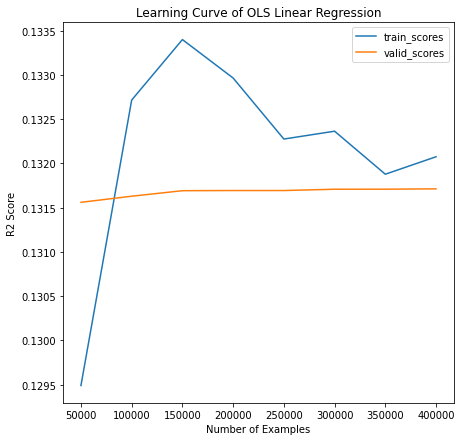

In [ ]:
plot_learning_curve(train_sizes, train_scores, valid_scores, title = "Learning Curve of OLS Linear Regression", y_label = "R2 Score")

As we can see, model is severely suffered from underfitting and it is not result we want for the baseline model (because it seems that validation score is flatten no matter we increate the number of samples). Then we decided to increase our complexity by using [Polynomial Regression](https://en.wikipedia.org/wiki/Polynomial_regression#:~:text=In%20statistics%2C%20polynomial%20regression%20is,nth%20degree%20polynomial%20in%20x.) which increases the number of dimensions in our data.



### Polynomial Regression

First, we create a poly transformer and transform X into X_transformed (with regard to the polynominal factor)

In [ ]:
poly_feature = PolynomialFeatures(degree=3, include_bias=False) # Class polynomial to create polynominal features
X_transformed = poly_feature.fit_transform(X)  # Transform the feature
X_transformed.shape

(550068, 219)

Due to the limitation of our computer, we are only tried until degree <= 3

Then we train the model

In [ ]:
poly_lr = LinearRegression(n_jobs = -1 )
metrics = {'R2' : R2_score, 'RMSE': RMSE_score}
sv_scores = cross_validate(olr, X_transformed, y, cv = 5, scoring =metrics, return_train_score = True)

In [ ]:
df_sv_scores = pd.DataFrame(sv_scores)
df_sv_scores.append([df_sv_scores.mean().rename('mean', inplace=True) ,df_sv_scores.std().rename('std', inplace=True) ])

,fit_time,score_time,test_R2,train_R2,test_RMSE,train_RMSE
0,29.823039,0.182509,0.301322,0.298738,-4187.100017,-4209.258026
1,31.940382,0.133560,0.298145,0.299528,-4216.985111,-4201.802177
2,16.153348,0.069453,0.298751,0.299369,-4211.188325,-4203.268630
3,15.948416,0.073186,0.299134,0.299280,-4207.133915,-4204.268992
4,20.302477,0.078928,0.296339,0.299998,-4209.428217,-4203.633088
mean,22.833532,0.107527,0.298738,0.299383,-4206.367117,-4204.446182
std,7.586565,0.049363,0.001799,0.000454,11.370634,2.838298


In [ ]:
df_results = df_results.append({"Model" : "Polynomial Regression " , 
                    "Settings" : "n = 3",
                   'RMSE mean': 4206.367117,
                   'RMSE std':11.370634, 
                   'R2 mean':  0.298738, 
                   'R2 std': 0.001799, 
                   'Training time': 2.203541 , 
                   'Prediction time': 0.007358,
                   'Note' : '5-fold cross-validation'
                   }, 
                  ignore_index = True)

The `R2_score` is nearly `0.3`, which is almost double compared to `OLS`, so we also check whether this model is still underfit or not ?

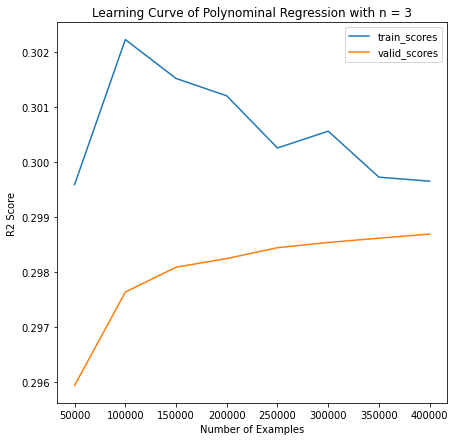

In [ ]:
## Learning Curve
train_sizes, train_scores, valid_scores = learning_curve(poly_lr, X_transformed, y, train_sizes=[50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000], scoring = R2_score)
plot_learning_curve(train_sizes, train_scores, valid_scores, title = "Learning Curve of Polynominal Regression with n = 3", y_label = "R2 Score")

So as we expected, the `R2_score` increase as we expand the dimensions of features however the model is still underfit (the training score is unstable when increase number of examples) so we decided to choose other algorithm families (which is not variants of Linear Regression).

Because the dependent features in the dataset are all categorical so we all think about `Decision Tree` as decision tree work best when each attribute is nominal/categorical and this problem is regression so we choose to the model `Decision Tree Regressor`.

### Decision Tree Regressor

In [ ]:
## Common parameters setting
dtr = DecisionTreeRegressor(max_depth = 3, min_samples_leaf=5, random_state= RANDOM_STATE)

metrics = {'R2' : R2_score, 'RMSE': RMSE_score}
sv_scores = cross_validate(dtr, X, y, cv = 5, scoring =metrics, return_train_score = True)

In [ ]:
df_sv_scores = pd.DataFrame(sv_scores)
df_sv_scores.append([df_sv_scores.mean().rename('mean', inplace=True) ,df_sv_scores.std().rename('std', inplace=True)])

,fit_time,score_time,test_R2,train_R2,test_RMSE,train_RMSE
0,0.591690,0.019044,0.444132,0.443503,-3734.742098,-3749.702290
1,0.596647,0.016814,0.443551,0.443648,-3754.836709,-3744.683014
2,0.570339,0.017624,0.446555,0.442892,-3741.154119,-3748.110014
3,0.589770,0.017117,0.441733,0.444103,-3754.824849,-3744.686547
4,0.573262,0.018369,0.442102,0.444011,-3748.166476,-3746.349108
mean,0.584342,0.017794,0.443615,0.443631,-3746.744850,-3746.706195
std,0.011766,0.000914,0.001920,0.000482,8.776502,2.193573


As we expected, the model is much faster and produces better result `R2_score = 0.44` than the two above models. But we need to check whether the model is underfit or not.

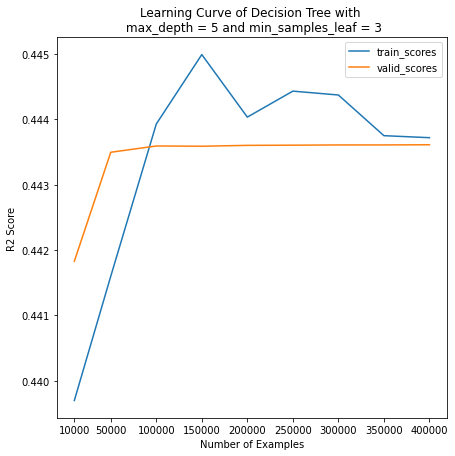

In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(dtr, X, y, train_sizes=[10000, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000], scoring = R2_score)
plot_learning_curve(train_sizes, train_scores, valid_scores, title = "Learning Curve of Decision Tree with \n max_depth = 5 and min_samples_leaf = 3", y_label = "R2 Score")

As we can see, the model still suffers from underfit (the pattern is the same as OLS Regression). However, we will do hyperparameters tuning to choose the best the best one as we believe it could be better if changing suitable hyperparameters and use it by [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)



#### Tuning hyperparameters

In [ ]:
# Selected Parameters
tuned_parameters = [
      {'max_depth' : [1, 5, 10, 11,  12, 15, 25, 30, 35, 40, 45,50],
       'min_samples_leaf' : [1, 3, 5, 10 , 15, 20,23, 25, 33, 30, 35, 40]}]

#Grid Search 
dtrGrid = GridSearchCV(DecisionTreeRegressor(random_state=RANDOM_STATE),tuned_parameters, n_jobs = -1, cv = 5, scoring = R2_score ) ##Scoring using R2_score
dtrGrid.fit(X, y)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=7777),
             n_jobs=-1,
             param_grid=[{'max_depth': [1, 5, 10, 11, 12, 15, 25, 30, 35, 40,
                                        45, 50],
                          'min_samples_leaf': [1, 3, 5, 10, 15, 20, 23, 25, 33,
                                               30, 35, 40]}],
             scoring=make_scorer(r2_score))

In [ ]:
print("The best setting for DTR:")
dtrGrid.best_estimator_

The best setting for DTR:


DecisionTreeRegressor(max_depth=25, min_samples_leaf=40, random_state=7777)

In [ ]:
pdtGrid_result = pd.DataFrame.from_dict(dtrGrid.cv_results_)
columns = ['mean_fit_time', 'mean_score_time', 'params', 'mean_test_score' ,'std_test_score']
## Top 5 parameter settings
pdtGrid_result[columns].sort_values(by='mean_test_score', ascending=False).head(5)

,mean_fit_time,mean_score_time,params,mean_test_score,std_test_score
83,4.651169,0.046293,"{'max_depth': 25, 'min_samples_leaf': 40}",0.703399,0.002116
95,4.359856,0.046527,"{'max_depth': 30, 'min_samples_leaf': 40}",0.703377,0.002152
143,4.284841,0.043604,"{'max_depth': 50, 'min_samples_leaf': 40}",0.703358,0.002147
131,4.422129,0.046214,"{'max_depth': 45, 'min_samples_leaf': 40}",0.703358,0.002147
119,4.355248,0.056009,"{'max_depth': 40, 'min_samples_leaf': 40}",0.703358,0.002147


So we train and validate again with the optimal parameter.

In [ ]:
sv_scores = cross_validate(DecisionTreeRegressor(random_state = RANDOM_STATE, max_depth=25, min_samples_leaf=40), X, y, cv = 5, scoring =metrics, return_train_score = True)

In [ ]:
df_sv_scores = pd.DataFrame(sv_scores)
df_sv_scores.append([df_sv_scores.mean().rename('mean', inplace=True) ,df_sv_scores.std().rename('std', inplace=True)])

,fit_time,score_time,test_R2,train_R2,test_RMSE,train_RMSE
0,2.205344,0.027637,0.690044,0.705594,-2788.847879,-2727.336507
1,2.430691,0.055169,0.692501,0.707433,-2791.259088,-2715.521459
2,2.536519,0.029280,0.698336,0.706116,-2762.041616,-2722.267105
3,2.601381,0.032739,0.694767,0.707217,-2776.414191,-2717.637810
4,2.120070,0.031591,0.692084,0.706075,-2784.567688,-2723.913328
mean,2.378801,0.035283,0.693546,0.706487,-2780.626092,-2721.335242
std,0.208649,0.011292,0.003160,0.000796,11.824947,4.769726


#### Choosing model based on the result of tuning hyperparameter

In [ ]:
dtrGrid.best_estimator_

DecisionTreeRegressor(max_depth=25, min_samples_leaf=40, random_state=7777)

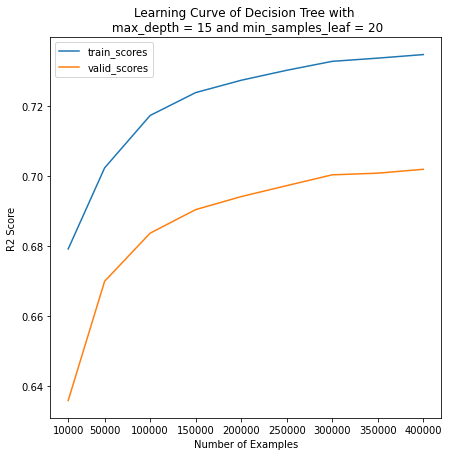

In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(dtrGrid.best_estimator_, X, y, train_sizes=[10000, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000], scoring = R2_score)
plot_learning_curve(train_sizes, train_scores, valid_scores, title = "Learning Curve of Decision Tree with \n max_depth = 15 and min_samples_leaf = 20", y_label = "R2 Score")

Validation score and training score are both high (up to nearly `0.7 R2 Score` for validation curve) however there is a big gap between `train_scores` and `valid_scores` and two curves then to meet each other when increase the number of examples so it is a *overfitting* model .

In [ ]:
df_results = df_results.append({"Model" : "Decision Tree Regressor" , 
                    "Settings" : "max_depth = 15, min_sample_leaf = 20 ",
                   'RMSE mean':2785.145741,
                   'RMSE std':10.395473	, 
                   'R2 mean':  0.697248, 
                   'R2 std': 0.002545, 
                   'Training time': 2.154469 , 
                   'Prediction time': 0.026188,
                   'Note' : '5-fold cross-validation'
                   }, 
                  ignore_index = True)

Although `Decision Tree` yields good result, we also tried `Random Forest` which includes different decision trees and hopefully give us lower variances related to the data.

### Random Forest Regressor

In [ ]:
## Create RFR with selected paramater by similar techniques
rfr = RandomForestRegressor(max_depth = None, min_samples_split= 5, random_state= RANDOM_STATE, n_jobs = -1, max_features="sqrt", n_estimators= 100)

metrics = {'R2' : R2_score, 'RMSE': RMSE_score}
sv_scores = cross_validate(rfr, X, y, cv = 5, scoring =metrics, return_train_score = True)

We chose the parameters based on GridSearch strategies like above.

In [ ]:
df_sv_scores = pd.DataFrame(sv_scores)
df_sv_scores.append([df_sv_scores.mean().rename('mean', inplace=True) ,df_sv_scores.std().rename('std', inplace=True)])

,fit_time,score_time,test_R2,train_R2,test_RMSE,train_RMSE
0,92.548009,5.328763,0.696571,0.892352,-2759.329152,-1649.179942
1,79.302978,5.120703,0.698201,0.892577,-2765.266586,-1645.465077
2,79.537216,5.422899,0.701758,0.891956,-2746.332950,-1650.601569
3,78.133725,5.120395,0.697861,0.892239,-2762.308632,-1648.728728
4,78.692635,5.426194,0.697564,0.892704,-2759.675403,-1645.761772
mean,81.642913,5.283791,0.698391,0.892366,-2758.582544,-1647.947418
std,6.120640,0.154068,0.001978,0.000293,7.251973,2.242384


Suprisingly, the `mean_train_R2 = 0.89` which is much higher than other models while the `mean_validation_R2 = 0.698` and the variance indeed decreases `std_train_train_R2 = 0.000182`  but we wonder if the model is overfitting (big gap between train and validation score however in theory, it can not be happen as we decrease the variance)

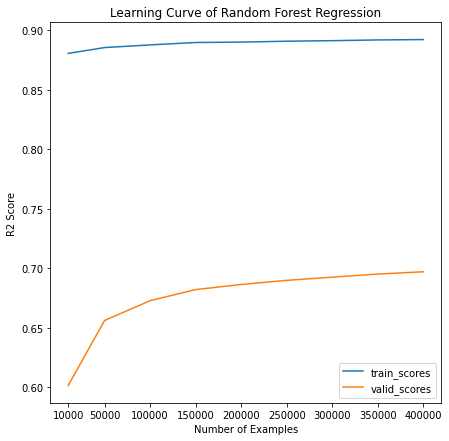

In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(rfr, X, y, train_sizes=[10000, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000], scoring = R2_score)
plot_learning_curve(train_sizes, train_scores, valid_scores, title = "Learning Curve of Random Forest Regression", y_label = "R2 Score")

Indeed, we can easily see that the model is *overfitting*. So we decided to find the answer for the question "Why RF decreases the variances but it still suffers from overfitting?". Refer to this [article](https://mljar.com/blog/random-forest-overfitting/), they conclude that the generalization error variance is decreasing to zero in the RF when more trees are added to the algorithm. However, the bias of the generalization does not change. So it does not completely solve the overfitting problem and they suggest we need to consider other parameters of RF.

In [ ]:
df_results = df_results.append({"Model" : "Random Forest Regressor" , 
                    "Settings" : "n_estimators= 100 , min_samples_split= 5,\n max_features= sqrt ",
                   'RMSE mean':2758.582544,
                   'RMSE std':7.251973, 
                   'R2 mean':  0.697248, 
                   'R2 std': 0.002545, 
                   'Training time': 2.154469 , 
                   'Prediction time': 0.026188,
                   'Note' : '5-fold cross-validation'
                   }, 
                  ignore_index = True)

RF is a bagging algorithm in ensemble learning so we also wanted to try another ensemble learning algorithm which is boosting. In this problem, we chose XGB Regressor as a reprensetative of all possible boosting algorithms.

### XGB Regressor

In [ ]:
## Create xgbModel with selected paramater by similar techniques
xgbModel = XGBRegressor(objective ='reg:squarederror', random_state = RANDOM_STATE, n_estimator = 200, max_depth = 9 , subsample = 0.8)

metrics = {'R2' : R2_score, 'RMSE': RMSE_score}
sv_scores = cross_validate(xgbModel, X, y, cv = 5, scoring =metrics, return_train_score = True)

In [ ]:
df_sv_scores = pd.DataFrame(sv_scores)
df_sv_scores.append([df_sv_scores.mean().rename('mean', inplace=True) ,df_sv_scores.std().rename('std', inplace=True)])

,fit_time,score_time,test_R2,train_R2,test_RMSE,train_RMSE
0,96.313929,1.169103,0.725803,0.746387,-2623.048482,-2531.341670
1,88.573103,1.177289,0.726777,0.746279,-2631.097194,-2528.823941
2,86.125638,1.173696,0.730221,0.745714,-2611.994307,-2532.234595
3,85.714028,1.183153,0.728017,0.746733,-2620.833811,-2527.596825
4,87.321798,1.250761,0.726636,0.746713,-2623.685695,-2528.610259
mean,88.809699,1.190800,0.727491,0.746365,-2622.131898,-2529.721458
std,4.340814,0.033911,0.001719,0.000415,6.857236,1.968204


Obviously, the result is much better than aforementioned models so we wonder if it is well-fit or not? 

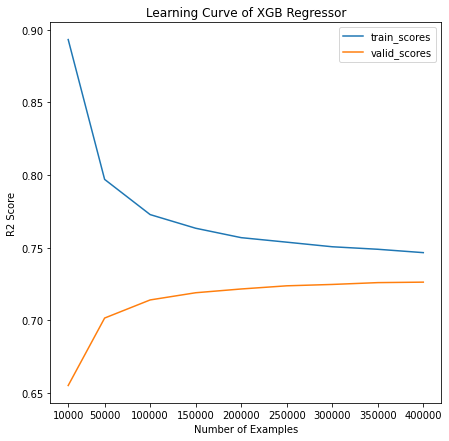

In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(xgbModel, X, y, train_sizes=[10000, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000], scoring = R2_score)
plot_learning_curve(train_sizes, train_scores, valid_scores, title = "Learning Curve of XGB Regressor", y_label = "R2 Score")

Indeed, the model is *well-fit*. However we think we can improve the model more by better tuning parameters.

In [ ]:
df_results = df_results.append({"Model" : "XGB Regressor" , 
                    "Settings" : "n_estimators= 100, min_samples_split= 5 ",
                   'RMSE mean':2665.562251,
                   'RMSE std':6.067515, 
                   'R2 mean':  0.718388, 
                   'R2 std': 0.001881	, 
                   'Training time':63.005356	, 
                   'Prediction time': 0.984860,
                   'Note' : '5-fold cross-validation'
                   }, 
                  ignore_index = True)

We also wanted to try some instance-based models which is contradictory to our problem (which has a large number of sample) to see what would happen. K-Nearest Neighbors can yield better results than other models in general. However due to the limitation of hardware and the size of the dataset, we could only tried when the number of neighbors is less than 11. 

### K-Nearest Neighbors

Data preprocessing for KNN (as it's different)

In [ ]:
X_copy = X.copy()

In [ ]:
X_copy = pd.get_dummies(X, columns = ['Product_Category_1']).drop(['User_ID', 'Product_ID'] , 1)

As the time complexity of KNN is primally based on the number of instances in the dataset so we did not use cross-validation to evaluate KNN, instead of that, we just splitted our data into two parts (2 : 1)



In [ ]:
VAL_SIZE = 1 / 3 # Based on the lecture, we choose the popular split between Dtrain and Dtest
X_train, X_val, y_train, y_val = train_test_split(X_copy, y ,test_size= VAL_SIZE, random_state=RANDOM_STATE)

In [ ]:
knn = KNeighborsRegressor(n_neighbors = 30, weights="uniform")
knnPipeline = make_pipeline(RobustScaler(), knn)

In [ ]:
timer.start()
knnPipeline.fit(X_train, y_train)
timer.tick("Training time for KNN: ")

Training time for KNN:  : 0.69119 seconds


In [ ]:
timer.start()
y_val_pred = knnPipeline.predict(X_val)
timer.tick("Prediction time for KNN: ")

Prediction time for KNN:  : 1510.58379 seconds


In [ ]:
print("R2 score of KNN: ", end = "")
print(r2_score(y_val, y_val_pred))
print("RMSE score of KNN: ", end = "")
print(myRMSE(y_val, y_val_pred))

R2 score of KNN: 0.6501166755970839
RMSE score of KNN: 2975.195710299609


It takes a long time to predict the results of validation set but we wonder if the number of `K` increase, what could happened ?

In [ ]:
df_results = df_results.append({"Model" : "K-Nearest Neighbors" , 
                    "Settings" : "n = 10",
                   'RMSE mean':3289.2392923276598,
                   'RMSE std':0, 
                   'R2 mean':  0.5723552890467303, 
                   'R2 std': 0.0, 
                   'Training time':1.09672 , 
                   'Prediction time': 1095.67261,
                   'Note' : 'Hold-old (2:1)'
                   }, 
                  ignore_index = True)

We also tried to use collaborative filtering algorithm in recommendation systems.

### Collaborative Filtering (Code by our team members)

In [ ]:
trainset, valset = train_test_split(train_raw, test_size = TEST_SIZE, random_state = RANDOM_STATE)

In [ ]:
def partition (list_in, n):
    random.shuffle(list_in)
    return [list_in[i::n] for i in range(n)]

class Recommendation_System:
  def __init__(self, train):
    self.train = train

    self.price = self.train.groupby(['Product_Category_1']).Purchase.agg(['min', 'max'])
    self.price['range'] = self.price['max'] - self.price['min']
    

  def processing_data(self, data):
    data['rating'] = 5*(data['Purchase'] - data['Purchase'].min())/(data['Purchase'].max() - data['Purchase'].min())

    # hash user id
    user_id_dict = {}
    for idx, val in enumerate(list(data.User_ID.unique())):
      user_id_dict[val] = idx

    # hash product id
    product_id_dict = {}
    for idx, val in enumerate(list(data.Product_ID.unique())):
      product_id_dict[val] = idx

    # generate rating and status matrices
    rating = np.zeros((len(user_id_dict), len(product_id_dict)))
    status = np.zeros((len(user_id_dict), len(product_id_dict)))

    # set rating and status values
    for idx, row in data.iterrows():
      u = user_id_dict[row['User_ID']]
      p = product_id_dict[row['Product_ID']]

      rating[u, p] = row.rating
      status[u, p] = 1

    df_rating = pd.DataFrame(rating, columns = list(product_id_dict.keys()), index = list(user_id_dict.keys()))

    df_status = pd.DataFrame(status, columns = list(product_id_dict.keys()), index = list(user_id_dict.keys()))

    user_attribute = data.groupby(['User_ID',])[['Gender',	'Age', 	'Occupation', 'City_Category',	'Stay_In_Current_City_Years',	'Marital_Status']].apply(lambda x: x.mode().iloc[0])
    df_user = pd.DataFrame(user_attribute).sort_values(by=['User_ID'])
    # df_user = df_user.set_index('User_ID')
    df_user = pd.get_dummies(df_user)


    df_product = pd.DataFrame(np.random.rand(rating.shape[1], df_user.shape[1]), columns = list(df_user.columns), index = list(product_id_dict.keys()))

    self.n_u = df_rating.shape[0]
    self.n_p = df_rating.shape[1]

    return df_user, df_product, df_rating, df_status, user_id_dict, product_id_dict


  def costfunction(self, X, y, r, theta, Lambda):
    predictions = np.dot(X, theta.T)* r
    err = predictions-y
    J = 1/2 * np.sum(np.sum((err**2) ))
    reg_x = Lambda/2 * np.sum(np.sum(theta**2))
    reg_theta = Lambda/2 * np.sum(np.sum(X**2))
    return J + reg_x + reg_theta


  def sgd(self, X, y, r, theta, batch_size, Lambda, num_iter, alpha):
    n_batch = int(self.n_u/batch_size)
    J_hist = []
    for i in range(num_iter):
      batch = partition (list(range(self.n_u)), n_batch)

      for i in range(len(batch)):

        temp_X = X.iloc[batch[i]]
        temp_Y = y.iloc[batch[i]]
        temp_r = r.iloc[batch[i]]


        cost = self.costfunction(temp_X, temp_Y, temp_r, theta, Lambda)
        theta = theta - alpha*(np.dot((np.dot(temp_X, theta.T)*temp_r - temp_Y).T, temp_X) + Lambda*theta) 
        J_hist.append(cost)
    return theta, J_hist


  def normalizeRatings(self, y, r):
    ymean = np.sum(y, axis=1)/np.sum(r, axis=1)
    ynorm = np.sum(y, axis=1)*np.sum(r, axis=1) - ymean
    return ymean, ynorm
  
  def fit(self):

    df_train_user, df_train_product, df_train_rating, df_train_status, user_dict, product_dict = self.processing_data(self.train)
    # df_test_user, df_test_product, df_test_rating, df_test_status = self.processing_train(test_data)

    lr = [0.00001, 0.00003]
    hist = []
    for ilr in lr:
      theta, J_hist = self.sgd(df_train_user, df_train_rating, df_train_status, df_train_product,500, 10, 20, ilr)
      hist.append(J_hist)

    self.theta = theta

    return hist

  def getProduct(self):
    return self.theta

  def predict(self, test):
    test_copy = test.copy()
    mean = pd.DataFrame(self.theta.describe().loc['mean'])

    if 'Purchase' not in test.columns:
      test['Purchase'] = np.nan

    df_test_user, df_test_product, df_test_rating, df_test_status, user_dict, product_dict  = self.processing_data(test_copy)

    # set all new product attribute equal to mean
    idx = list(mean.index)

    for i in range(len(idx)):
      df_test_product[idx[i]] = mean.iloc[[i], [0]].values[0, 0]


    similarity_idx = df_test_product.index.intersection(self.theta.index)

    df_test_product.loc[similarity_idx] = self.theta.loc[similarity_idx]

    self.theta = self.theta.append(df_test_product.loc[df_test_product.index.difference(self.theta.index)])

    result = np.dot(df_test_user, df_test_product.T)* df_test_status
    result.columns = list(product_dict)

    result = pd.DataFrame(result, index=list(user_dict))

    # test_copy.predict = np.nan

    for i, r in test.iterrows():
      test_copy.at[i , 'Purchase'] = result.loc[[r.User_ID], [r.Product_ID]].values[0, 0] * self.price.loc[[r.Product_Category_1]].values[0, 2] /5 + self.price.loc[[r.Product_Category_1]].values[0, 0]

    return test_copy

In [ ]:
rs = Recommendation_System(trainset)

In [ ]:
timer.start()
hist = rs.fit()
timer.tick("Training time for CF: ")

Training time for CF:  : 108.94674 seconds


In [ ]:
rs_pred_trainset = rs.predict(trainset)

In [ ]:
timer.start()
rs_pred_valset = rs.predict(valset)
timer.tick("Prediction time for RS: ")

Prediction time for RS:  : 348.57836 seconds


In [ ]:
rs_pred_trainset_result_y = rs_pred_trainset['Purchase']
trainset_y = trainset['Purchase']
rs_pred_valset_result_y = rs_pred_valset['Purchase']
valset_y = valset['Purchase']

In [ ]:
print("RMSE of the val set:", end = " ")
print(myRMSE(rs_pred_valset_result_y, valset_y))

RMSE of the val set: 3957.8777145845484


In [ ]:
print("R2 of the val set:", end = " ")
print(r2_score(rs_pred_valset_result_y, valset_y))

R2 of the val set: 0.2549792742266995


The result is not as we expected but it just likes our experiment.

In [ ]:
df_results = df_results.append({"Model" : "Collaborative Filtering" , 
                    "Settings" : "",
                   'RMSE mean':3954.5903809282186,
                   'RMSE std':0, 
                   'R2 mean':  0.251581680682041, 
                   'R2 std': 0.0, 
                   'Training time':119.46289 , 
                   'Prediction time': 328.58785,
                   'Note' : 'Hold-out (2:1)'
                   }, 
                  ignore_index = True)

## 8.&nbsp;Conclusion

In [ ]:
# Beautiful format 
df_results.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap',})

,Model,Settings,Training time,Prediction time,RMSE mean,RMSE std,R2 mean,R2 std,Note
0,OLS Linear Regression,,0.201613,0.020742,4680.566008,11.079699,0.131713,0.003413,5-fold cross-validation
1,Polynomial Regression,n = 3,2.203541,0.007358,4206.367117,11.370634,0.298738,0.001799,5-fold cross-validation
2,Decision Tree Regressor,"max_depth = 15, min_sample_leaf = 20",2.154469,0.026188,2785.145741,10.395473,0.697248,0.002545,5-fold cross-validation
3,Random Forest Regressor,"n_estimators= 100 , min_samples_split= 5, max_features= sqrt",2.154469,0.026188,None,None,0.697248,0.002545,5-fold cross-validation
4,XGB Regressor,"n_estimators= 100, min_samples_split= 5",63.005356,0.984860,2665.562251,6.067515,0.718388,0.001881,5-fold cross-validation
5,K-Nearest Neighbors,n = 10,1.096720,1095.672610,3289.239292,0,0.572355,0.000000,Hold-old (2:1)
6,Collaborative Filtering,,119.462890,328.587850,3954.590381,0,0.251582,0.000000,Hold-out (2:1)


As we can see, the best model is `XGB Regressor` with `R2_score = 0.718` and `RMSE = 2665.56`  